In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Load datasets
data = pd.read_csv("/Users/wiktor/TIC/Spring2026-TIC/data/merged_prices_weather.csv")

# Set date as index
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

# Define the spread, which will later be replaced by our estimate, but for now we need it to get the volatility and to label the data
data['spread'] = np.log(data['corn_Close']) - np.log(data['soybean_Close'])


In [ ]:
def get_daily_vol(close, span0=100):
    # Basically we want to get the volatility of the price, but we care more about recent volatility,
    # so we use an exponentially weighted moving standard deviation.
    df0 = close.diff() 
    
    # Standard deviation of returns
    df0 = df0.ewm(span=span0).std()
    return df0

def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    Apply Stop Loss (SL) and Profit Take (PT) to the price series.
    
    events: DataFrame with:
        - t1: The timestamp of the vertical barrier (max holding period)
        - trgt: The unit width of the horizontal barriers, this is the volatility estimate at the time of the event
    pt_sl: A list of two non-negative float values:
        - pt_sl[0]: The factor that multiplies trgt to set the stop loss
        - pt_sl[1]: The factor that multiplies trgt to set the profit taking
    molecule: A list with the subset of indices that we will process
    """
    # Select events happening in this subset (molecule)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    # If profit taking is active (pt_sl[1] > 0)
    if pt_sl[1] > 0:
        pt = pt_sl[1] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs

    # If stop loss is active (pt_sl[0] > 0)
    if pt_sl[0] > 0:
        sl = -pt_sl[0] * events_['trgt']
    else:
        sl = pd.Series(index=events.index) # NaNs

    # Loop through each event to find the first barrier touch
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1] # Price path from entry to max holding period
        df0 = (df0 / close[loc]) - 1 # Cumulative returns
        
        # Earliest stop loss touch
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()
        # Earliest profit take touch
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()
        
    return out

In [5]:
def get_events(close, t_events, pt_sl, target, min_ret, num_threads=1, vertical_barrier_times=False, side=None):
    # 1) Get target
    target = target.loc[t_events]
    target = target[target > min_ret] # Exclude events with too low vol
    
    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        t1 = pd.Series(pd.NaT, index=t_events)
    else:
        t1 = vertical_barrier_times
        
    # 3) Form events object
    if side is None:
        side_ = pd.Series(1.0, index=target.index)
    else:
        side_ = side.loc[target.index]
        
    # FIX: Ensure all series have the same unique index before concatenating
    # We intersection the indices to make sure we only concat valid overlapping data
    common_idx = target.index.intersection(t1.index).intersection(side_.index)
    
    # Reindex everything to this common unique index
    events = pd.DataFrame({
        't1': t1.loc[common_idx], 
        'trgt': target.loc[common_idx], 
        'side': side_.loc[common_idx]
    })
    
    events = events.dropna(subset=['trgt'])
    
    # Apply Triple Barrier
    df0 = apply_pt_sl_on_t1(close=close, events=events, pt_sl=pt_sl, molecule=events.index)
    
    # 4) Determine which barrier was touched first
    events['t1'] = df0.dropna(how='all').min(axis=1) # The time of the first touch
    
    if side is None:
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        pt_sl_ = pt_sl[:2]
    
    return events

# === RELOAD DATA & RETRY ===

# 1. Deduplicate first!
data = data[~data.index.duplicated(keep='first')]

# 2. Recalculate Volatility on unique data
daily_vol = get_daily_vol(data['spread'])

# 3. Recalculate Vertical Barriers on unique data
# (Previous t1 might have had different length/index due to duplicates)
t1_indices = data.index.searchsorted(data.index + pd.Timedelta(days=10))
# Handle edge case where searchsorted returns index out of bounds
t1_indices = t1_indices[t1_indices < len(data.index)]
# Map integer indices back to DatetimeIndex
t1 = pd.Series(data.index[t1_indices], index=data.index[:len(t1_indices)])

# 4. Run Triple Barrier
events = get_events(
    close=data['spread'],
    t_events=data.index, 
    pt_sl=[1, 1],
    target=daily_vol,
    min_ret=0.005,
    vertical_barrier_times=t1
)

print("Events generated successfully:", events.shape)

# 4. Generate Labels (-1, 0, 1) from the Events
def get_bins(events, close):
    """
    Label observations based on the outcome of the Triple Barrier.
    Returns:
        ret: The return realized at the time of the first barrier touch.
        bin: The label (-1 for SL, 1 for PT, 0 for Vertical Barrier if applicable).
    """
    # 1) Align prices with events
    events_ = events.dropna(subset=['t1'])
    px_init = close.loc[events_.index]
    px_end = close.loc[events_['t1']]
    
    # 2) Calculate Return
    ret = (px_end.values / px_init.values) - 1
    
    # 3) Assign Labels
    out = pd.DataFrame(index=events_.index)
    out['ret'] = ret
    out['bin'] = np.sign(ret) # +1 or -1
    
    # Note: Refinements can be made here to handle the vertical barrier (0) case specifically
    return out

labels = get_bins(events, data['spread'])
print("Labels generated:", labels['bin'].value_counts())

Events generated successfully: (5297, 3)
Labels generated: bin
 1.0    2728
-1.0    2566
 0.0       1
Name: count, dtype: int64


In [7]:
class PurgedKFold(KFold):
    """
    Extended K-Fold class to handle purging and embargoing.
    """
    def __init__(self, n_splits=3, t1=None, pct_embargo=0.0):
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        # Ensure t1 is a Series with the same index as the data we will split
        self.t1 = t1
        self.pct_embargo = pct_embargo

    def split(self, X, y=None, groups=None):
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pct_embargo)
        
        # Ensure X has a datetime index for time comparison
        if not isinstance(X.index, pd.DatetimeIndex):
             raise ValueError("X must have a DatetimeIndex for PurgedKFold to work.")

        for train_indices, test_indices in super(PurgedKFold, self).split(X, y, groups):
            
            # 1. Define Test Window Dates
            test_start_date = X.index[test_indices[0]]
            test_end_date = X.index[test_indices[-1]]
            
            # 2. Define Embargo Time (Date after which training can resume)
            # We find the integer index of the end of test set + embargo buffer
            embargo_idx = min(test_indices[-1] + mbrg, X.shape[0] - 1)
            embargo_date = X.index[embargo_idx]
            
            # 3. Purge Training Data
            train_indices_purged = []
            
            # We need both the Integer index (for output) and the Date (for logic)
            # Since self.t1 aligns with X, we can use iloc for slicing
            
            # Fetch t1 (end times) for the training set using INTEGER indexing
            t1_train = self.t1.iloc[train_indices]
            
            # Iterate through training indices to check for overlap
            for i, t1_val in zip(train_indices, t1_train.values):
                # t0_val is the start date of this specific training sample
                t0_val = X.index[i]
                
                # CHECK 1: Leakage (Train ends inside Test window)
                # If a training trade ends AFTER test starts, and starts BEFORE test ends.
                if t1_val >= test_start_date and t0_val <= test_end_date:
                    continue
                    
                # CHECK 2: Embargo (Train starts immediately after Test)
                # If the test set is older than the train set, we must wait (embargo)
                if test_end_date <= t0_val < embargo_date:
                    continue
                    
                train_indices_purged.append(i)
            
            yield np.array(train_indices_purged), test_indices

In [8]:
# 1. Align Data
common_idx = labels.index.intersection(data.index)
X = data.loc[common_idx]
y = labels.loc[common_idx, 'bin']
t1_reduced = events.loc[common_idx, 't1']

# 2. Initialize
cv = PurgedKFold(n_splits=5, t1=t1_reduced, pct_embargo=0.01)

# 3. Iterate
# This loop should now run without KeyError
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    print(f"Fold {i+1}: Train size {len(train_idx)}, Test size {len(test_idx)}")
    
    # Optional: Verify dates to ensure gap
    train_dates = X.index[train_idx]
    test_dates = X.index[test_idx]
    print(f"  Test:  {test_dates.min().date()} -> {test_dates.max().date()}")
    # We want to make sure training doesn't 'touch' the test window

Fold 1: Train size 4186, Test size 1060
  Test:  2005-01-05 -> 2009-03-19
Fold 2: Train size 4182, Test size 1060
  Test:  2009-03-20 -> 2013-06-05
Fold 3: Train size 4184, Test size 1059
  Test:  2013-06-06 -> 2017-08-21
Fold 4: Train size 4184, Test size 1059
  Test:  2017-08-22 -> 2021-11-03
Fold 5: Train size 4236, Test size 1059
  Test:  2021-11-04 -> 2026-01-23


Data rows available for Cointegration: 5303
Cointegration p-value: 0.01588
Hedge Ratio (Beta): 1.0850

--- ECM Results ---
Gamma (Mean Reversion Speed): -0.0055
P-value of Gamma: 0.0005


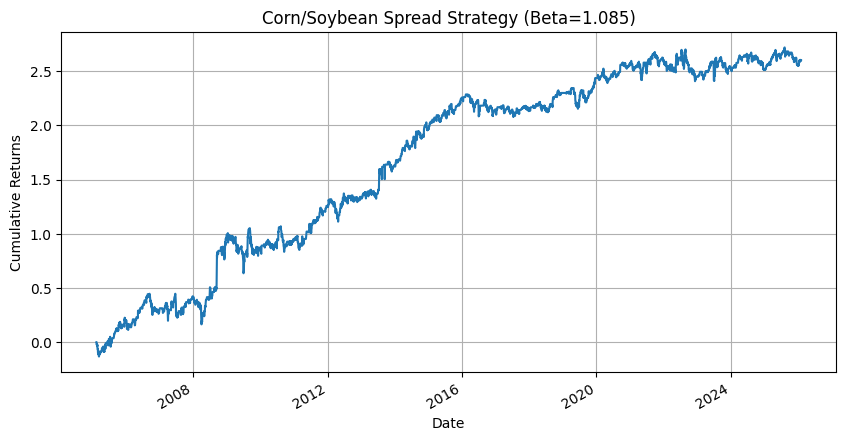

Annualized Sharpe Ratio: 0.57


In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# ======================================================
# 1. ROBUST DATA PREP (Fixes Beta = NaN)
# ======================================================
# Ensure we are working with clean data
model_data = data[['corn_Close', 'soybean_Close']].copy()

# Remove 0 or negative values before log to avoid -inf
model_data = model_data[model_data > 0].dropna()

# Log Transform
model_data['log_corn'] = np.log(model_data['corn_Close'])
model_data['log_soy'] = np.log(model_data['soybean_Close'])

# Drop any NaNs created by log (just in case)
model_data = model_data.dropna()

print(f"Data rows available for Cointegration: {len(model_data)}")

# ======================================================
# 2. COINTEGRATION & HEDGE RATIO
# ======================================================
y = model_data['log_corn']
x = model_data['log_soy']

# Test Cointegration
# We add 'c' (Constant) explicitly for the test if needed, but ts.coint handles it.
coint_t, p_value, crit_value = ts.coint(y, x)
print(f"Cointegration p-value: {p_value:.5f}")

# Estimate Beta (Hedge Ratio)
# add_constant is required for the intercept
x_const = sm.add_constant(x)
results_ols = sm.OLS(y, x_const).fit()
beta = results_ols.params['log_soy']

print(f"Hedge Ratio (Beta): {beta:.4f}")

if np.isnan(beta):
    print("CRITICAL ERROR: Beta is still NaN. Check for infinite values in data.")
else:
    # Construct the Spread (The specific linear combination that is stationary)
    # We map this back to the original 'data' dataframe's index
    data['coint_spread'] = data['corn_Close'].apply(np.log) - beta * data['soybean_Close'].apply(np.log)

# ======================================================
# 3. ECM ESTIMATION
# ======================================================
# We re-calculate diffs on the full dataset, but handle NaNs carefully
ecm_df = pd.DataFrame()
ecm_df['dy'] = data['corn_Close'].apply(np.log).diff()
ecm_df['dx'] = data['soybean_Close'].apply(np.log).diff()
ecm_df['spread_lag'] = data['coint_spread'].shift(1)

# Drop NaNs for the regression
ecm_clean = ecm_df.dropna()

if not ecm_clean.empty:
    ecm_model = sm.OLS(ecm_clean['dy'], sm.add_constant(ecm_clean[['spread_lag', 'dx']]))
    ecm_res = ecm_model.fit()
    print("\n--- ECM Results ---")
    print(f"Gamma (Mean Reversion Speed): {ecm_res.params['spread_lag']:.4f}")
    print(f"P-value of Gamma: {ecm_res.pvalues['spread_lag']:.4f}")
else:
    print("ECM Data is empty.")

# ======================================================
# 4. BACKTEST (Z-Score Strategy)
# ======================================================
# Calculate Z-Score
window = 30
rolling_mean = data['coint_spread'].rolling(window=window).mean()
rolling_std = data['coint_spread'].rolling(window=window).std()
data['z_score'] = (data['coint_spread'] - rolling_mean) / rolling_std

# Drop initialization period for backtesting
bt_data = data.dropna(subset=['z_score']).copy()

if not bt_data.empty:
    # Define Signals
    bt_data['position'] = 0
    # Sell Spread (Corn is expensive relative to Soy)
    bt_data.loc[bt_data['z_score'] > 1.0, 'position'] = -1 
    # Buy Spread (Corn is cheap)
    bt_data.loc[bt_data['z_score'] < -1.0, 'position'] = 1 
    # Exit
    bt_data.loc[abs(bt_data['z_score']) < 0.5, 'position'] = 0 
    
    # Fix for deprecated method='ffill' in replace
    # Logic: We want to hold the position until an exit signal (0) or reversal
    # A simple trick is to mask 0s as NaNs, ffill, then fill 0s back
    # But wait! '0' IS a signal here (Exit). We only want to fill if "nothing happened".
    # In this simple Z-score logic, the zones between 0.5 and 1.0 are "Holding" zones.
    
    # Correct Vectorized "Holding" Logic:
    # 1. Identify Entry/Exit events
    conditions = [
        (bt_data['z_score'] > 1),   # Short Signal
        (bt_data['z_score'] < -1),  # Long Signal
        (abs(bt_data['z_score']) < 0.5) # Exit Signal
    ]
    choices = [-1, 1, 0]
    
    # Create a signal series (NaN where no action is taken, i.e., holding zone)
    bt_data['signal'] = np.select(conditions, choices, default=np.nan)
    
    # Forward fill the signal (hold previous state)
    bt_data['position'] = bt_data['signal'].ffill().fillna(0)
    
    # Calculate PnL
    # Spread PnL = Position * Change in Spread
    bt_data['strategy_ret'] = bt_data['position'].shift(1) * bt_data['coint_spread'].diff()
    
    # Plot
    plt.figure(figsize=(10, 5))
    bt_data['strategy_ret'].cumsum().plot()
    plt.title(f"Corn/Soybean Spread Strategy (Beta={beta:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.grid(True)
    plt.show()
    
    sharpe = (bt_data['strategy_ret'].mean() / bt_data['strategy_ret'].std()) * np.sqrt(252)
    print(f"Annualized Sharpe Ratio: {sharpe:.2f}")

else:
    print("Backtest data is empty (likely due to insufficient history for rolling window).")

Hedge Ratio (Beta): 1.0850
Interpretation: A 1% move in Soybeans implies a 1.0850% move in Corn.

ADF Statistic: -3.7477
P-Value: 0.00349
Result: COINTEGRATION DETECTED. The spread is mean-reverting.


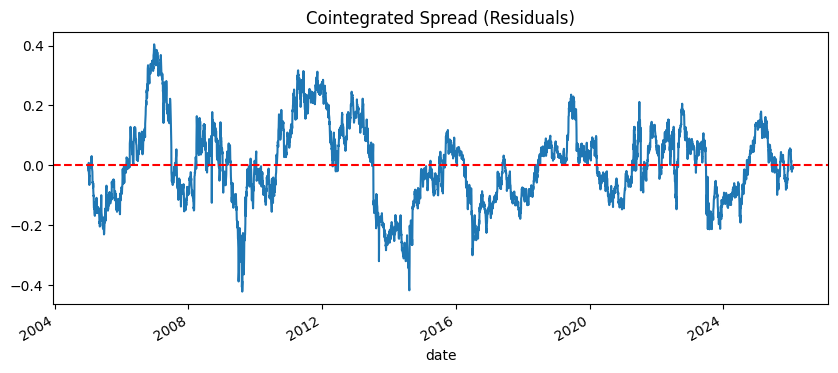

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# 1. Prepare Data (Log Prices)
# We use logs so the beta represents a percentage ratio (elasticity), not just a dollar ratio.
# Ensure no NaNs or Infs
clean_data = data[['corn_Close', 'soybean_Close']].dropna()
clean_data = clean_data[(clean_data > 0).all(axis=1)] # Remove 0 or negative values

y = np.log(clean_data['corn_Close'])    # Dependent Variable
x = np.log(clean_data['soybean_Close']) # Independent Variable

# 2. Estimate Hedge Ratio (Beta) via OLS
# log(Corn) = Beta * log(Soybean) + c + epsilon
x_const = sm.add_constant(x)
results_ols = sm.OLS(y, x_const).fit()
beta = results_ols.params['soybean_Close']
const = results_ols.params['const']

print(f"Hedge Ratio (Beta): {beta:.4f}")
print(f"Interpretation: A 1% move in Soybeans implies a {beta:.4f}% move in Corn.")

# 3. Construct the Spread (The Residuals)
# Spread = log(Corn) - Beta * log(Soybean) - Constant
# This 'spread' is what we trade. It should be stationary (mean-reverting).
clean_data['spread'] = y - (beta * x) - const

# 4. Test for Cointegration (ADF Test on Spread)
# Null Hypothesis: Spread is Non-Stationary (Random Walk).
# Alternate Hypothesis: Spread is Stationary (Cointegrated).
adf_result = ts.adfuller(clean_data['spread'])

print(f"\nADF Statistic: {adf_result[0]:.4f}")
print(f"P-Value: {adf_result[1]:.5f}")

if adf_result[1] < 0.05:
    print("Result: COINTEGRATION DETECTED. The spread is mean-reverting.")
else:
    print("Result: NO COINTEGRATION. The spread is a random walk (Do not trade).")

# Plot the Spread
plt.figure(figsize=(10, 4))
clean_data['spread'].plot(title='Cointegrated Spread (Residuals)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [21]:
# 1. Prepare Differences (Returns)
dy = y.diff().rename('dy')  # Change in Corn
dx = x.diff().rename('dx')  # Change in Soybean

# 2. Get Lagged Spread
# The "Error" we observed yesterday that needs correcting today
spread_lag = clean_data['spread'].shift(1).rename('spread_lag')

# 3. Align Data for Regression
ecm_df = pd.concat([dy, dx, spread_lag], axis=1).dropna()

# 4. Run ECM Regression
# Predict dy using Spread_Lag and dx
# We want to see if the Spread_Lag helps predict the change in Corn
X_ecm = sm.add_constant(ecm_df[['spread_lag', 'dx']])
Y_ecm = ecm_df['dy']

ecm_model = sm.OLS(Y_ecm, X_ecm).fit()

print(ecm_model.summary())

# 5. Interpret Gamma
gamma = ecm_model.params['spread_lag']
gamma_pval = ecm_model.pvalues['spread_lag']

print(f"\n--- ECM Key Results ---")
print(f"Gamma (Speed of Adjustment): {gamma:.4f}")
print(f"Is Gamma Significant? {'YES' if gamma_pval < 0.05 else 'NO'} (p={gamma_pval:.4f})")

if gamma < 0:
    half_life = -np.log(2) / gamma
    print(f"Half-Life of Reversion: {half_life:.1f} days")
    print("Meaning: It takes about {:.0f} days for half of a price gap to close.".format(half_life))

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     1158.
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        14:28:17   Log-Likelihood:                 14574.
No. Observations:                5302   AIC:                        -2.914e+04
Df Residuals:                    5299   BIC:                        -2.912e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.692e-05      0.000      0.268      0.7